<a href="https://colab.research.google.com/github/chrs7n/FinalCapstoneProject/blob/main/FinalCapstone_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bank-customer-churn-prediction-dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
#--
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.tree import _tree
from collections import Counter


sns.set_style("whitegrid")
sns.set_palette("pastel")
pd.set_option("display.max_columns", None)

In [3]:
# Reading csv file
df = pd.read_csv(path + "/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# **Exploratory data analysis**

In [4]:

# Show dataset dimensions
print("Dataset shape:", df.shape)

# Show data types and missing values
print("\nColumn info:")
print(df.info())

# Descriptive statistics for numerical variables
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (10000, 14)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Descriptive statistics:
         RowNumber    C

In [5]:
# converting 'HasCrCard','IsActiveMember','Exited' columns to boolean

df['HasCrCard'] = df['HasCrCard'].astype('bool')
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
df['Exited'] = df['Exited'].astype('bool')


In [6]:
# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

num_cols = [col for col in num_cols if col not in ['RowNumber','CustomerId']] #,'HasCrCard','IsActiveMember','Exited']]

# Create subplot with 1 row and len(num_cols) columns
fig = make_subplots(rows=1, cols=len(num_cols), subplot_titles=num_cols)

# Add a boxplot for each numeric column
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Box(y=df[col], name=col, boxpoints='outliers'),
        row=1, col=i+1
    )

# Update layout for spacing
fig.update_layout(
    height=500,
    width=300 * len(num_cols),
    title_text="Boxplots of Numerical Features",
    showlegend=False
)

fig.show()

**Comments:** Outliers are identified in CreditScore, Age and NumOfProducts.
- The majority of customers have an acceptable Credit Scoring, mainly between 600 and 700
- Customer age is commonly between 30 and 45 years old. The younger ones are 20 years old
- The bank doesn't have many products, the maximum is 4 products but the average number of products is 1

In [7]:
# Columns to plot (in specified order)
#columns = ['id', 'price', 'year', 'odometer']

# Create subplot: 1 row, 4 columns
fig = make_subplots(rows=1, cols=6, subplot_titles=num_cols)

# Add histograms
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Histogram(x=df[col], name=col),
        row=1, col=i+1
    )

# Update layout
fig.update_layout(
    height=400,
    width=1600,
    title_text="Histograms of Numerical Features",
    showlegend=False
)

fig.show()

**Comments:**
- There is no much older people in the Age distribution, so the bank is focused in the most productive people of the countries.
- Seems to be an error in Balance variable, due to zero balance in an important number of accounts.
- Product penetration is low, a few customers have more than 2 products.

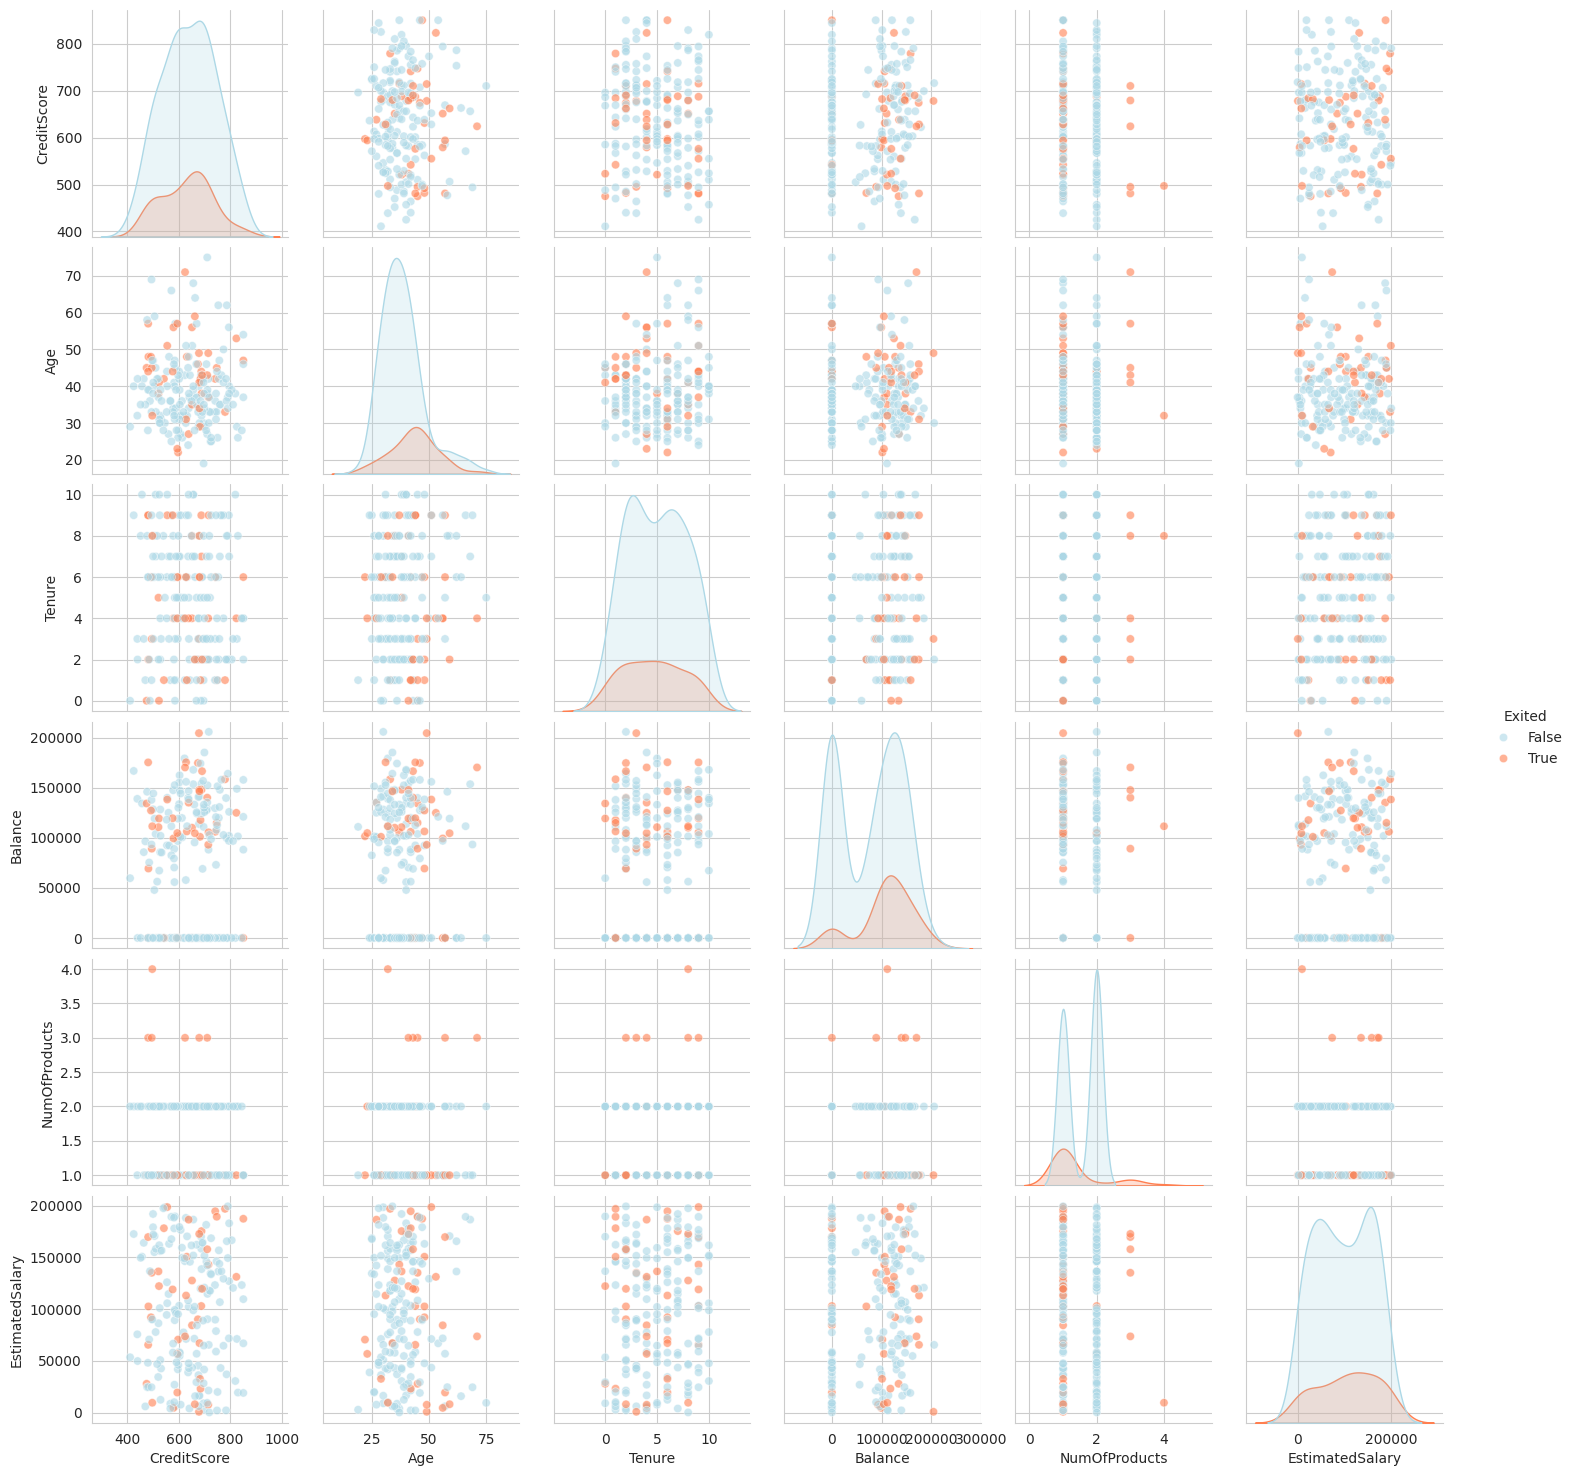

In [8]:
# Sample the data
df_sample = df.sample(n=200, random_state=42)

# Define a custom palette: 0 (Exited=False) -> green, 1 (Exited=True) -> red
custom_palette = {0: 'lightblue', 1: 'coral'}

# Create the pairplot
sns.pairplot(df_sample, vars=num_cols, hue='Exited', palette=custom_palette, diag_kind='kde',
             plot_kws={'alpha': 0.6})  # Adjust alpha for transparency
plt.show()


**Comments:** Seems to be low correlations accross variables.
- Number of products could be an important variable to classify churned customers
- customers who churned tend to be older than the others that stayed.
- Customers whi churned have an important concentration in 1 products. If customers have 2 products or more they are less likely to churn

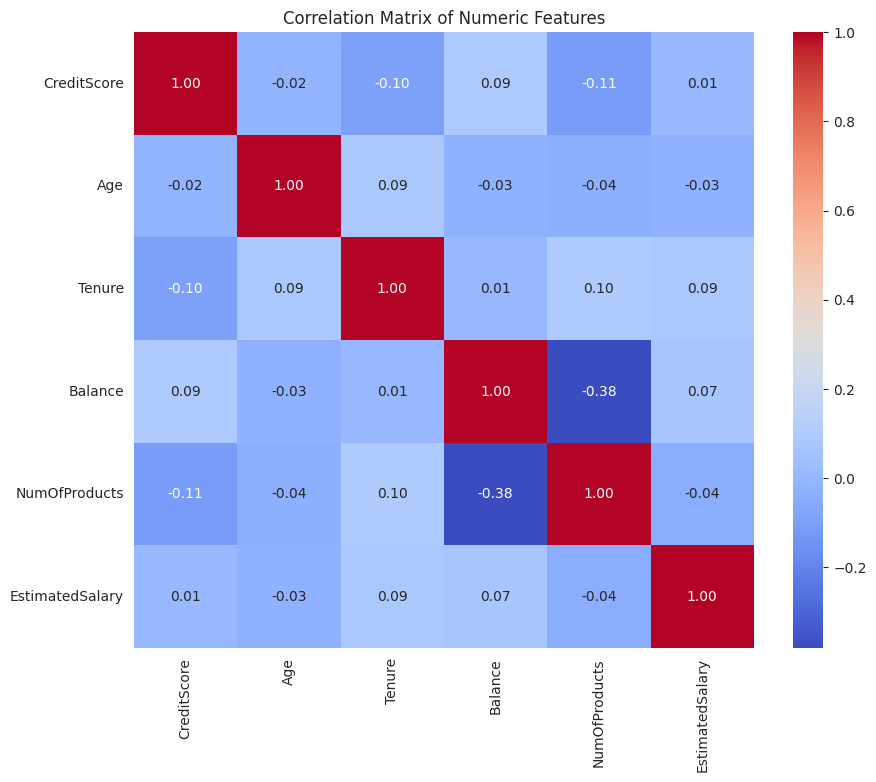

In [9]:
# Assuming df_sample is already defined as in the provided code.
#numeric_cols = df_sample.select_dtypes(include=np.number).columns

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_sample[num_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Comments:** Low correlations were identified between numeric variables. The highest correlation found is Number of products vs Balance (-0.38), followed by Number of products vs Credit Score (-0.11)

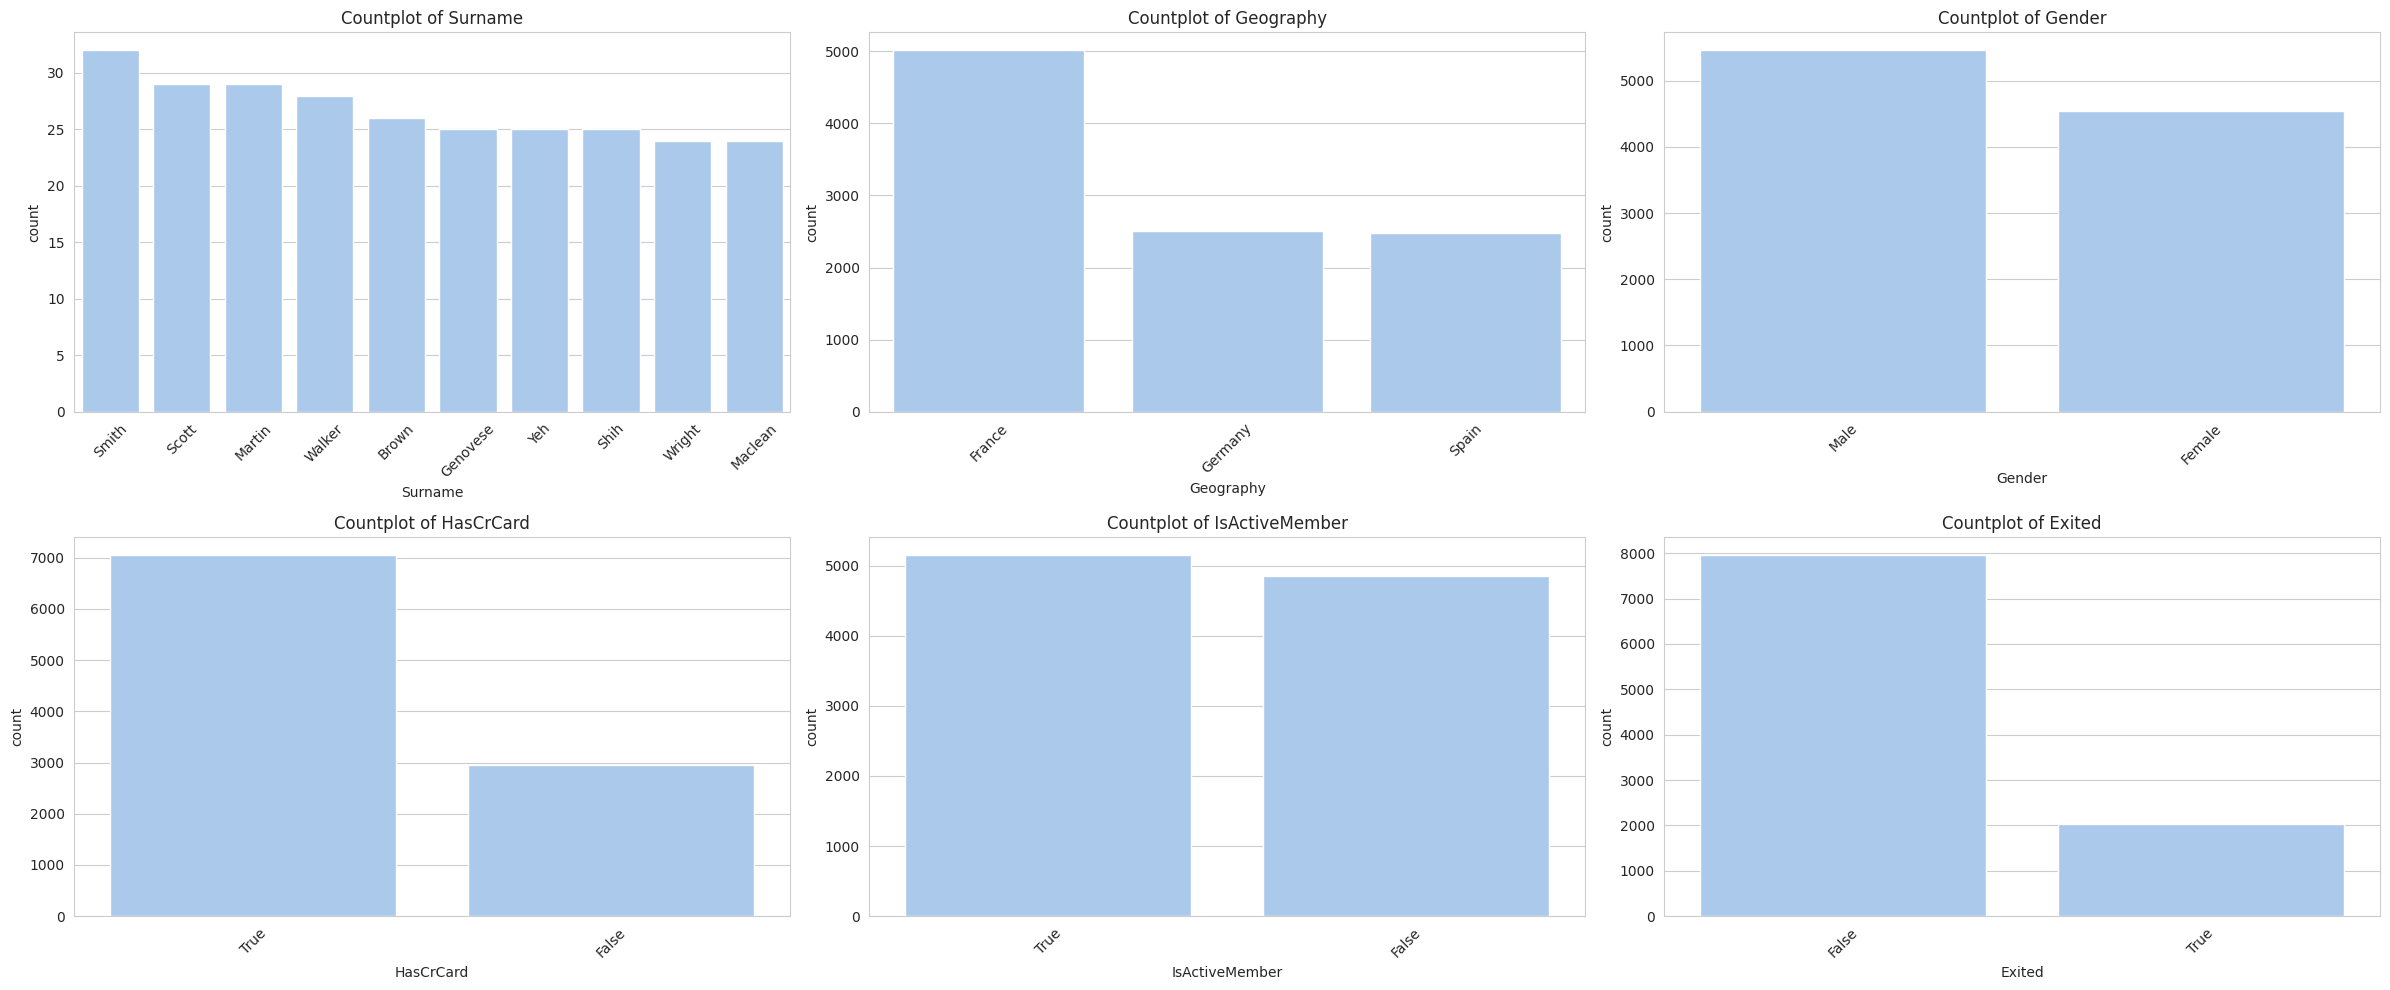

In [10]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object','boolean']).columns.tolist()

# Define grid layout: 4 columns per row
cols = 3
rows = math.ceil(len(cat_cols) / cols)

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(24, 5 * rows))
axes = axes.flatten()

# Generate a countplot for each categorical feature
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index[:10])
    axes[i].set_title(f'Countplot of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Exited
False    0.7963
True     0.2037
Name: proportion, dtype: float64


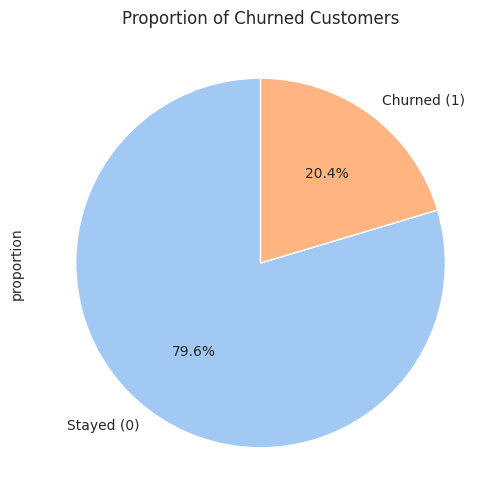

In [76]:
df.value_counts('Exited', normalize=True).plot(kind='pie',
    autopct='%1.1f%%',
    labels=['Stayed (0)', 'Churned (1)'],
    startangle=90,
    figsize=(6, 6), title='Proportion of Churned Customers',
    legend=False)

print(df.value_counts('Exited', normalize=True))

**Comments:** This dataset has a 20% of churned customers (this is the target variable) so it could be said that the dataset is **umbalanced**

In [12]:
# Detect missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
miss = missing_values.to_frame() #= missing_values[missing_values > 0]
miss = miss.rename(columns={0: 'counts'})
miss['porc_missing'] = (miss['counts']/df.shape[0])*100
miss

,counts,porc_missing
RowNumber,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


**Comments:** There is no missing values in the dataset

In [13]:
# Define the credit score ranges and labels
bins = [0, 580, 670, 740, 800, 999]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# Create the new column 'Grp_CreditScore' based on the credit score ranges
df['Grp_CreditScore'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)



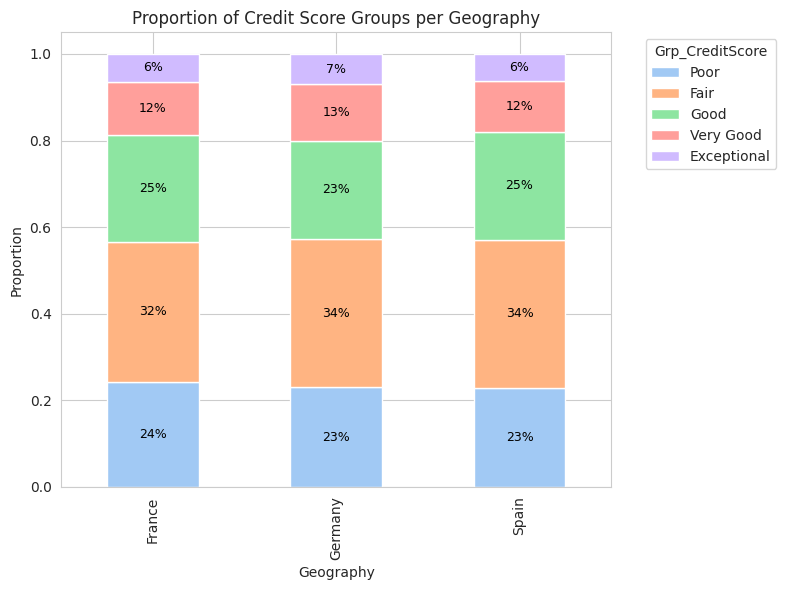

In [14]:

# Calcular proporciones
proportions = (
    df.groupby('Geography')['Grp_CreditScore']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Crear gráfico
ax = proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 6)
)

# Añadir etiquetas sobre cada segmento en color negro
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0.01:  # Mostrar solo si es mayor al 1%
            ax.annotate(
                f'{height:.0%}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center', va='center',
                fontsize=9, color='black'  # <- Etiquetas en negro
            )

plt.title('Proportion of Credit Score Groups per Geography')
plt.xlabel('Geography')
plt.ylabel('Proportion')
plt.legend(title='Grp_CreditScore', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




**Comments:** Proportions of the Credit Score groups are very similar across countries. The Credit policy of the bank must be the same in all countries

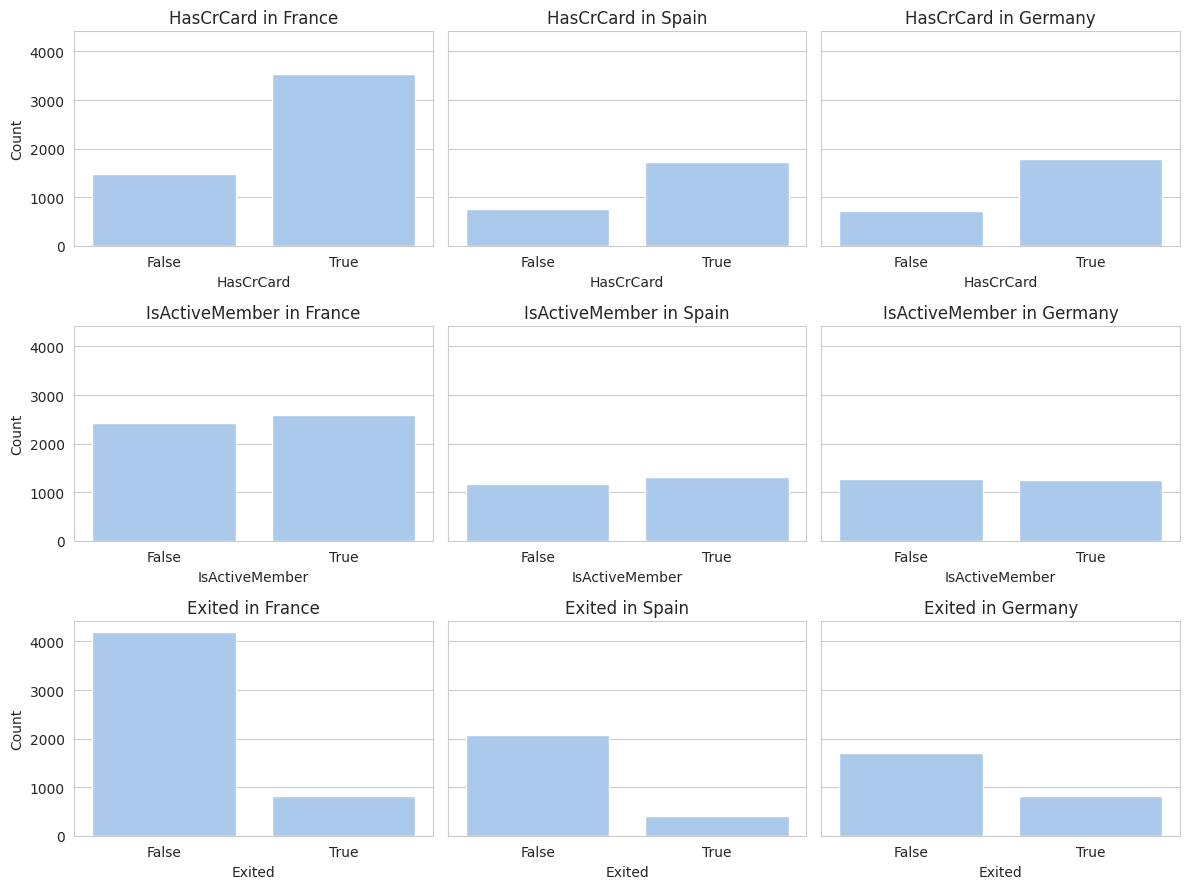

In [15]:
# Define boolean columns
bool_cols = ['HasCrCard', 'IsActiveMember', 'Exited']

# Unique geographies and boolean columns
geos = df['Geography'].unique()
rows = len(bool_cols)
cols = len(geos)

# Create subplots with one row per boolean variable, and one column per geography
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharey=True)

# Ensure axes is 2D
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Iterate through boolean variables and geographies
for i, col in enumerate(bool_cols):
    for j, geo in enumerate(geos):
        ax = axes[i][j]
        sns.countplot(x=col, data=df[df['Geography'] == geo], ax=ax)
        ax.set_title(f'{col} in {geo}')
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [16]:
df.groupby('Geography')['Exited'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Germany,2509,814,0.324432
Spain,2477,413,0.166734
France,5014,810,0.161548


**Comments:** There is more attrition as a ratio (2x) in Germany than the others countries

In [17]:
df.groupby('Geography')['HasCrCard'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Germany,2509,1791,0.713830
France,5014,3543,0.706621
Spain,2477,1721,0.694792


**Comments:** As a ratio, there is a similar level of cardholders accross countries

In [18]:
df.groupby('Geography')['IsActiveMember'].agg(['count', 'sum','mean']).sort_values(by='mean', ascending=False)

,count,sum,mean
Geography,,,
Spain,2477,1312,0.529673
France,5014,2591,0.516753
Germany,2509,1248,0.497409


**Comments:** The % of active members is similar in all countries. However Germany has the lower activation ratio

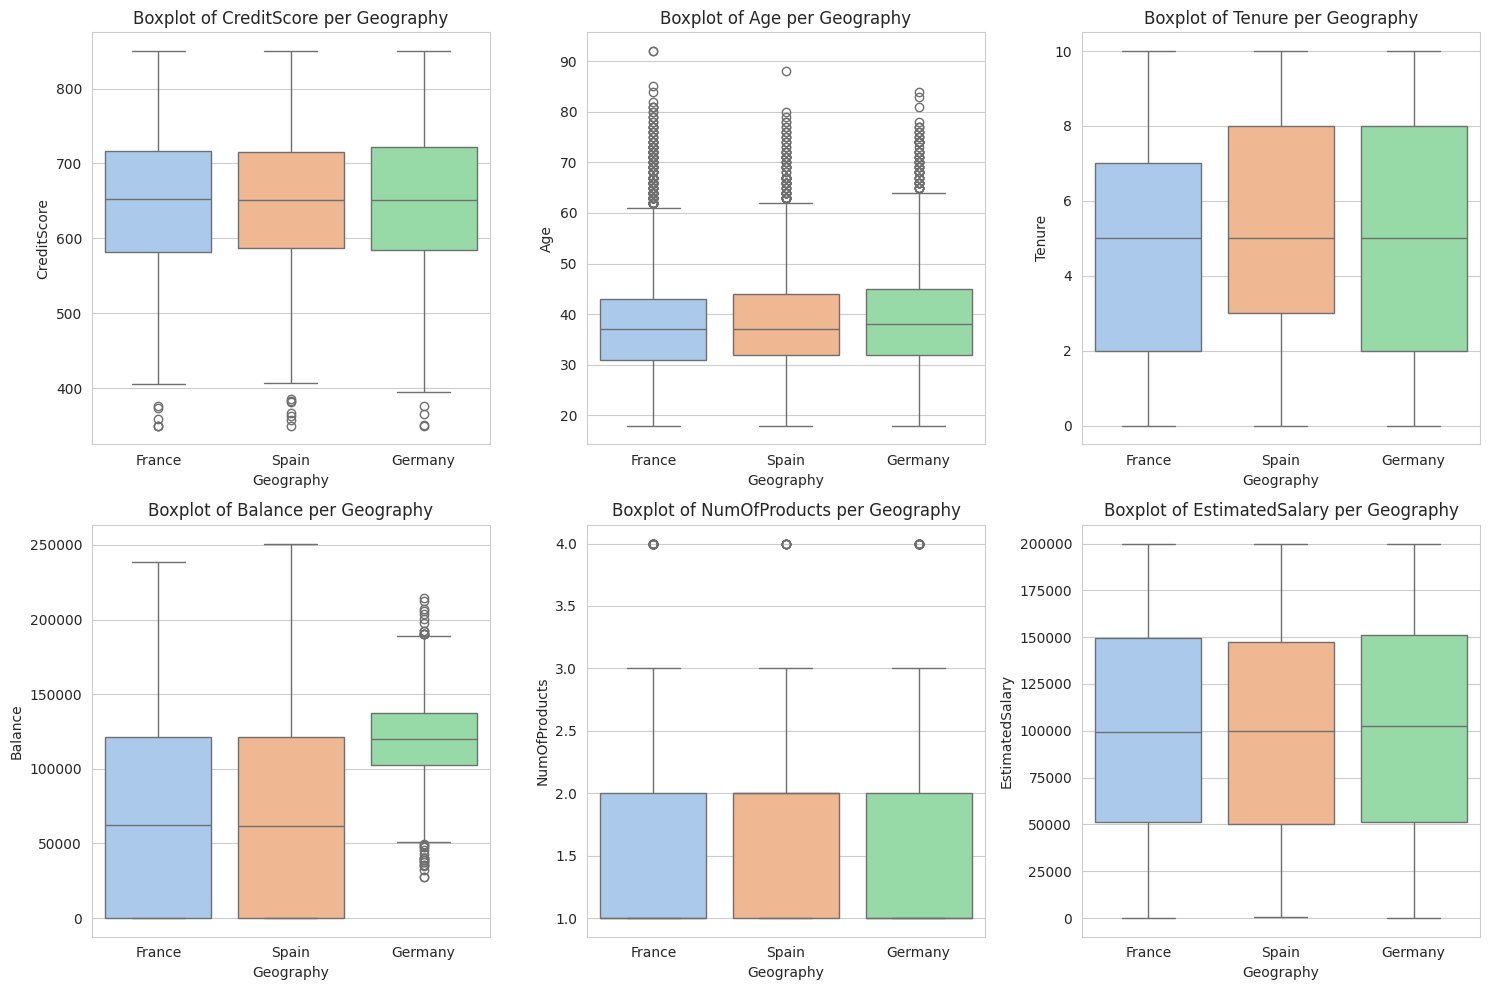

In [19]:
# Define the number of rows and columns for the subplots
n_rows = 2
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through numeric columns and create boxplots
for i, col in enumerate(num_cols):
    if i < len(axes):  # Check if we're still within the axes limits
        sns.boxplot(y=col, x='Geography', data=df, ax=axes[i], hue='Geography')
        axes[i].set_title(f'Boxplot of {col} per Geography')
    else:
        break  # Stop if we run out of axes

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


**Comments:** Numeric variables behave similarly accross geographies. Only Germany report a different Balance distribution

# **DATA PREPARATION**

**1. Dropping unnecessary columns**

In [20]:
df_cleaned = df.copy()
df_cleaned.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True)

In [21]:
df_cleaned.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Grp_CreditScore
0,619,France,Female,42,2,0.00,1,True,True,101348.88,True,Fair
1,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False,Fair
2,502,France,Female,42,8,159660.80,3,True,False,113931.57,True,Poor
3,699,France,Female,39,1,0.00,2,False,False,93826.63,False,Good
4,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False,Exceptional


In [22]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  object  
 2   Gender           10000 non-null  object  
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  bool    
 8   IsActiveMember   10000 non-null  bool    
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  bool    
 11  Grp_CreditScore  10000 non-null  category
dtypes: bool(3), category(1), float64(2), int64(4), object(2)
memory usage: 664.4+ KB


**2. Outliers Treatment**

In [23]:
# Seleccionar solo columnas numéricas (excluyendo la target)
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Inicializar una máscara para mantener filas válidas
mask = pd.Series(True, index=df_cleaned.index)

# Aplicar Z-score e IQR por cada columna numérica
for col in num_cols:
    # Z-score
    z = np.abs(zscore(df_cleaned[col]))
    z_mask = z < 3  # umbral típico

    # IQR
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_mask = (df_cleaned[col] >= Q1 - 1.5 * IQR) & (df_cleaned[col] <= Q3 + 1.5 * IQR)

    # Mantener filas que son válidas para ambas técnicas
    mask &= z_mask & iqr_mask

# Aplicar máscara directamente sobre df_cleaned
original_shape = df_cleaned.shape
df_cleaned = df_cleaned[mask]

# Reporte de cuántas filas fueron eliminadas
print(f"Total de filas eliminadas por outliers: {original_shape[0] - df_cleaned.shape[0]}")
print(f"Dataset final sin outliers: {df_cleaned.shape}")

Total de filas eliminadas por outliers: 432
Dataset final sin outliers: (9568, 12)


**3. Dropping rows with Balance = 0 treatment**

In [24]:
# prompt: drop rows with Balance = 0

# Assuming df_cleaned is already defined as in the provided code.
original_shape = df_cleaned.shape
df_cleaned = df_cleaned[df_cleaned['Balance'] != 0]

# Report number of rows removed
print(f"Total rows removed due to outliers in 'Balance': {original_shape[0] - df_cleaned.shape[0]}")
print(f"Final dataset shape without outliers: {df_cleaned.shape}")

Total rows removed due to outliers in 'Balance': 3465
Final dataset shape without outliers: (6103, 12)


**4. Outliers treatment in Balance variable after dropping "0" values**

In [25]:
# Numeric variable to consider
col = 'Balance'

# Initialize mask to keep valid rows
mask = pd.Series(True, index=df_cleaned.index)

# Z-score
z = np.abs(zscore(df_cleaned[col]))
z_mask = z < 3  # typical threshold

# IQR
Q1 = df_cleaned[col].quantile(0.25)
Q3 = df_cleaned[col].quantile(0.75)
IQR = Q3 - Q1
iqr_mask = (df_cleaned[col] >= Q1 - 1.5 * IQR) & (df_cleaned[col] <= Q3 + 1.5 * IQR)

# Keep rows valid in both techniques
mask &= z_mask & iqr_mask

# Apply mask directly to df_cleaned
original_shape = df_cleaned.shape
df_cleaned = df_cleaned[mask]

# Report number of rows removed
print(f"Total rows removed due to outliers in 'Balance': {original_shape[0] - df_cleaned.shape[0]}")
print(f"Final dataset shape without outliers: {df_cleaned.shape}")

Total rows removed due to outliers in 'Balance': 69
Final dataset shape without outliers: (6034, 12)


In [26]:
# Create subplot with 1 row and len(num_cols) columns
fig = make_subplots(rows=1, cols=len(num_cols), subplot_titles=num_cols)

# Add a boxplot for each numeric column
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Box(y=df_cleaned[col], name=col, boxpoints='outliers'),
        row=1, col=i+1
    )

# Update layout for spacing
fig.update_layout(
    height=500,
    width=300 * len(num_cols),
    title_text="Boxplots of Numerical Features",
    showlegend=False
)

fig.show()

<Axes: ylabel='proportion'>

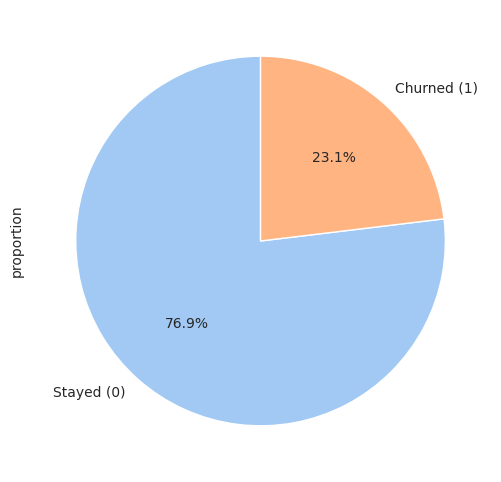

In [27]:
df_cleaned.value_counts('Exited', normalize=True).plot(kind='pie',
    autopct='%1.1f%%',
    labels=['Stayed (0)', 'Churned (1)'],
    startangle=90,
    figsize=(6, 6),
    legend=False)
#print(df_cleaned.value_counts('Exited', normalize=True))

In [28]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6034 entries, 1 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      6034 non-null   int64   
 1   Geography        6034 non-null   object  
 2   Gender           6034 non-null   object  
 3   Age              6034 non-null   int64   
 4   Tenure           6034 non-null   int64   
 5   Balance          6034 non-null   float64 
 6   NumOfProducts    6034 non-null   int64   
 7   HasCrCard        6034 non-null   bool    
 8   IsActiveMember   6034 non-null   bool    
 9   EstimatedSalary  6034 non-null   float64 
 10  Exited           6034 non-null   bool    
 11  Grp_CreditScore  6034 non-null   category
dtypes: bool(3), category(1), float64(2), int64(4), object(2)
memory usage: 448.0+ KB


**5. Data transformations and sampling**

In [29]:
# Separar variables predictoras y variable objetivo
X = df_cleaned.drop(columns='Exited')
y = df_cleaned['Exited']

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

# Preprocesamiento para modelos sensibles: escalamiento y one-hot encoding
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Codificar variables categóricas como enteros para RandomForest
X_train_rfc = X_train.copy()
X_test_rfc = X_test.copy()
for col in categorical_features:
    X_train_rfc[col] = X_train_rfc[col].astype('category').cat.codes
    X_test_rfc[col] = X_test_rfc[col].astype('category').cat.codes

**Codification of categorical variables**

**Geography:**
- 0 -> France
- 1 -> Germany
- 2 -> Spain

**Gender:**
- 0 -> Female
- 1 -> Male

**Grp_CreditScore:**
- 0 -> Poor
- 1 -> Fair
- 2 -> Good
- 3 -> Very Goog
- 4 -> Exceptional


**6. Balance data process**

In [30]:
# Preprocesar y balancear para modelos sensibles
X_train_preprocessed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# **MODELING**

In [74]:
# Models and grids definition
models = {
    'LogisticRegression': (
        Pipeline([
            ('poly', PolynomialFeatures(include_bias=False)),
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        {
            'poly__degree': [1, 2, 3],  # Grados del polinomio
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__class_weight': ['balanced']
        }
    ),
    'SVM': (
        SVC(),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    'RandomForest': (
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [3, 5, 8]}
    )
}

results = {}
best_estimators = {}

for model_name, (model, param_grid) in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'RandomForest':
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_rfc, y_train)
        y_pred = grid.predict(X_test_rfc)

    elif model_name == 'LogisticRegression':
        # El preprocesamiento + SMOTE se aplica fuera del pipeline
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_balanced, y_train_balanced)
        y_pred = grid.predict(X_test_preprocessed)

    else:
        # SVM usa datos ya preprocesados y balanceados
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid.fit(X_train_balanced, y_train_balanced)
        y_pred = grid.predict(X_test_preprocessed)

    report = classification_report(y_test, y_pred, output_dict=True)
    pos_label = list(report.keys())[-2]  # normalmente '1'

    results[model_name] = {
        'Best Params': grid.best_params_,
        'Test Accuracy': report['accuracy'],
        'Precision (class 1)': report[pos_label]['precision'],
        'Recall (class 1)': report[pos_label]['recall'],
        'F1-score (class 1)': report[pos_label]['f1-score']
    }

    best_estimators[model_name] = grid.best_estimator_



Training LogisticRegression...

Training SVM...

Training RandomForest...


In [75]:
pd.set_option('display.max_colwidth', None)

# Crear tabla comparativa
results_df = pd.DataFrame(results).T
print("\nComparación de modelos:\n")
results_df.round(3)



Comparación de modelos:



,Best Params,Test Accuracy,Precision (class 1),Recall (class 1),F1-score (class 1)
LogisticRegression,"{'clf__C': 10, 'clf__class_weight': 'balanced', 'poly__degree': 3}",0.778661,0.698186,0.724357,0.70833
SVM,"{'C': 10, 'kernel': 'rbf'}",0.772034,0.687964,0.708983,0.696448
RandomForest,"{'max_depth': 8, 'n_estimators': 100}",0.834327,0.814207,0.677025,0.708687


**Comments:**
The best model is selected base ond the F1-score of the possitive class (churned) because:
- It provides a good balance between Precision and Recall.
- It is specially useful when there is class imbalance (as is often the case with churned customers)
- It penalizes both false positives and false negatives

The winning model is RandomForest, as it achieved the highest F1-score (0.7087) and also has the highest Accuracy and Precision among all models.


Top 10 características más importantes en RandomForest:
Age                0.395959
NumOfProducts      0.193506
Balance            0.078457
IsActiveMember     0.070876
EstimatedSalary    0.070641
CreditScore        0.056151
Geography          0.052835
Tenure             0.035331
Gender             0.024414
Grp_CreditScore    0.014402
dtype: float64


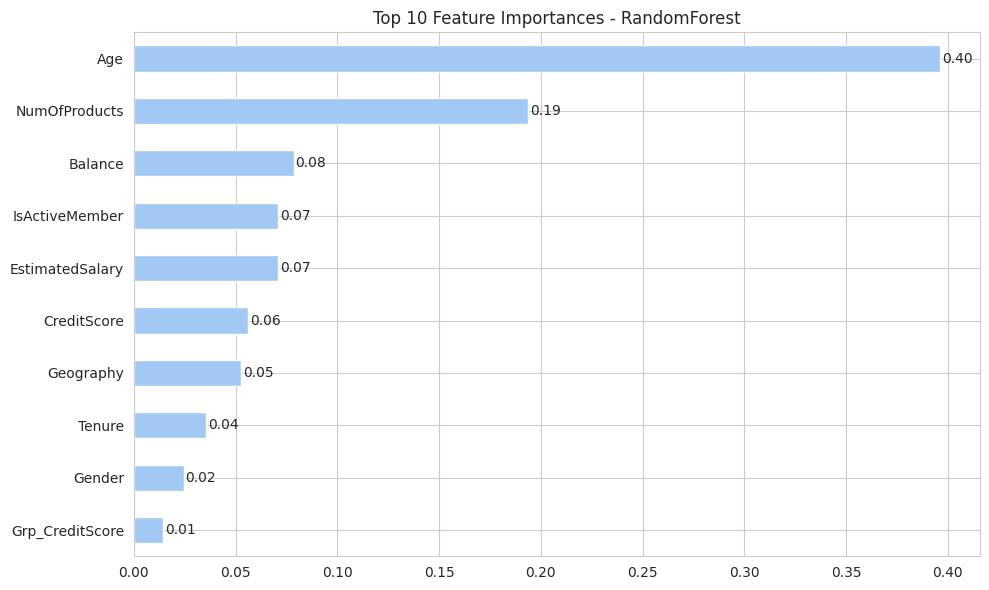

In [76]:
# Mostrar importancias y árbol de RandomForest
rf_model = best_estimators['RandomForest']
importances = pd.Series(rf_model.feature_importances_, index=X_train_rfc.columns)
importances_sorted = importances.sort_values(ascending=False)

print("\nTop 10 características más importantes en RandomForest:")
print(importances_sorted.head(10))

ax = importances_sorted.head(10).plot(kind='barh', figsize=(10, 6), title='Top 10 Feature Importances - RandomForest')
plt.gca().invert_yaxis()
for i, v in enumerate(importances_sorted.head(10)):
    ax.text(v + 0.001, i, f'{v:.2f}', va='center')
plt.tight_layout()
plt.show()

**Comments:** The most important features that help to classify churn customers are: Age and Number of Products. The rest of features have similar values of importance


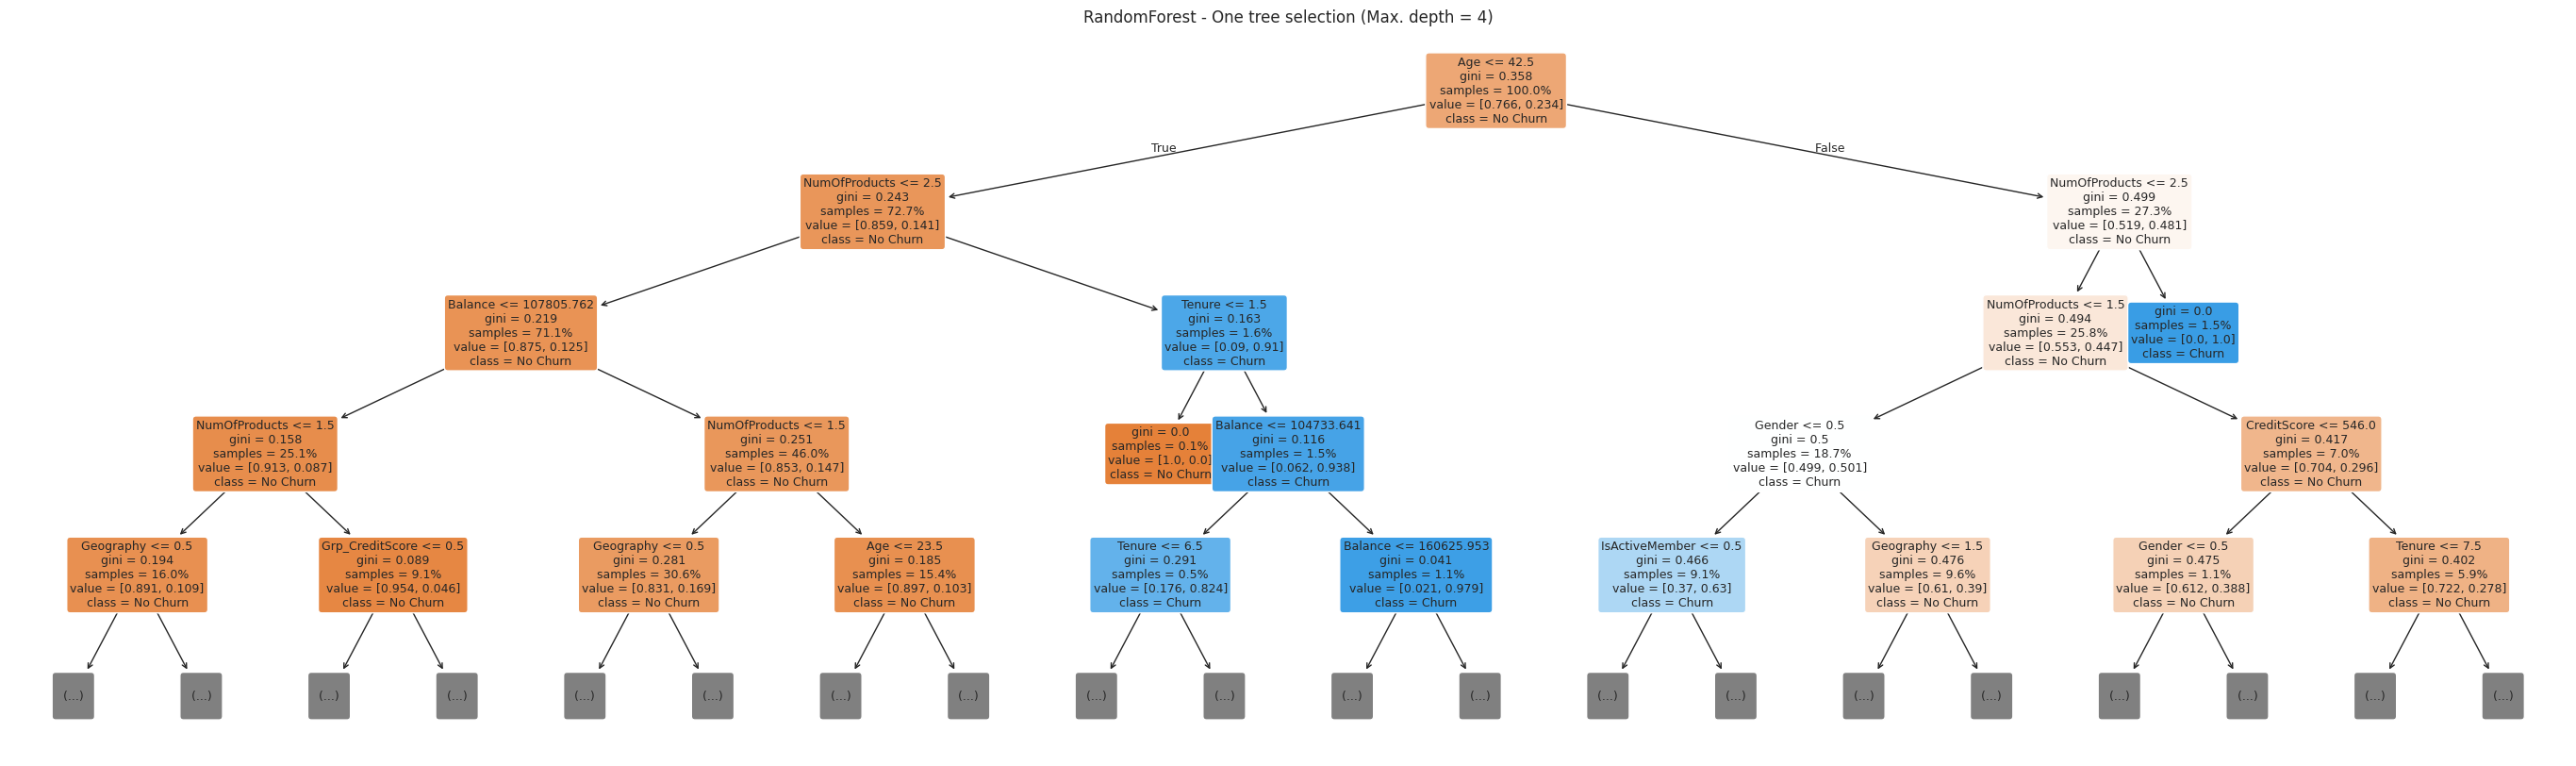

In [114]:
# Visualizar uno de los árboles del bosque (con profundidad limitada)
plt.figure(figsize=(35, 10))
plot_tree(rf_model.estimators_[95], feature_names=X_train_rfc.columns, class_names=['No Churn', 'Churn'], filled=True, rounded=True, proportion=True, max_depth=4,fontsize=9)
plt.title("RandomForest - One tree selection (Max. depth = 4)")
plt.show()

In [96]:
def extract_rules_for_class(tree, feature_names, class_value=1):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], path + [f"({name} <= {threshold:.2f})"])
            recurse(tree_.children_right[node], path + [f"({name} > {threshold:.2f})"])
        else:
            pred_class = np.argmax(tree_.value[node])
            if pred_class == class_value:
                rule = " AND ".join(path)
                paths.append(rule)

    recurse(0, [])
    return paths

# Extraer reglas de todos los árboles
best_rf = best_estimators['RandomForest']
feature_names = X_train_rfc.columns.tolist()

all_churn_rules = []

for i, tree in enumerate(best_rf.estimators_):
    churn_rules = extract_rules_for_class(tree, feature_names, class_value=1)
    all_churn_rules.extend(churn_rules)

# Contar frecuencia de cada regla
rule_counter = Counter(all_churn_rules)

# Mostrar las reglas más frecuentes
print("Top 10 reglas más comunes que predicen churn (Exited = 1):\n")
for rule, count in rule_counter.most_common(10):
    print(f"Veces: {count}")
    print(f"Regla: {rule}\n")


Top 10 reglas más comunes que predicen churn (Exited = 1):

Veces: 8
Regla: (Geography <= 0.50) AND (NumOfProducts > 2.50)

Veces: 4
Regla: (Age > 42.50) AND (NumOfProducts > 2.50)

Veces: 3
Regla: (NumOfProducts > 2.50) AND (Geography <= 0.50)

Veces: 2
Regla: (Geography > 0.50) AND (Age > 44.50) AND (IsActiveMember > 0.50) AND (NumOfProducts > 2.50)

Veces: 2
Regla: (NumOfProducts > 2.50) AND (Age <= 35.50) AND (Balance <= 125514.50)

Veces: 2
Regla: (NumOfProducts > 2.50) AND (Tenure > 1.50) AND (Age > 42.50)

Veces: 2
Regla: (Age > 45.50) AND (IsActiveMember > 0.50) AND (NumOfProducts > 2.50)

Veces: 2
Regla: (CreditScore <= 403.00)

Veces: 1
Regla: (Geography <= 0.50) AND (NumOfProducts <= 2.50) AND (Gender <= 0.50) AND (Tenure <= 7.50) AND (NumOfProducts <= 1.50) AND (Grp_CreditScore <= 0.50) AND (HasCrCard <= 0.50) AND (Age > 40.00)

Veces: 1
Regla: (Geography <= 0.50) AND (NumOfProducts <= 2.50) AND (Gender <= 0.50) AND (Tenure <= 7.50) AND (NumOfProducts <= 1.50) AND (Grp_Cred

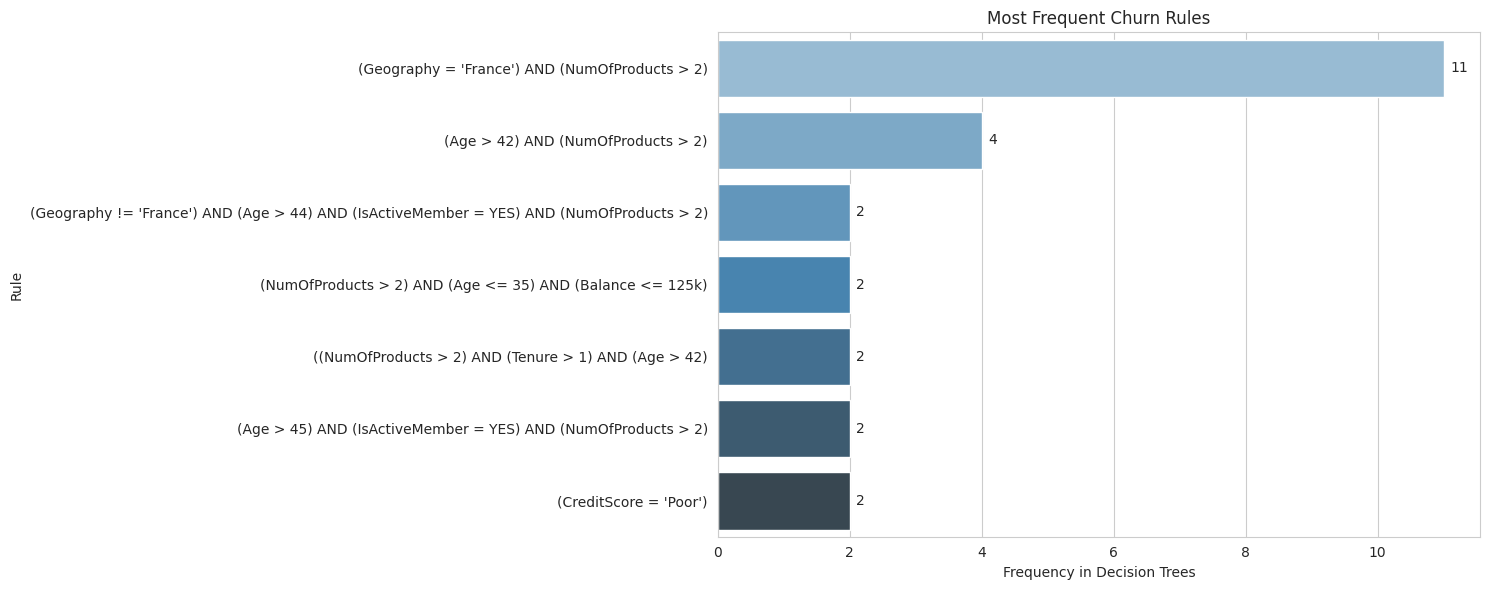

In [66]:
# Data
rules = [
    (11, "(Geography = 'France') AND (NumOfProducts > 2)"),
    (4, "(Age > 42) AND (NumOfProducts > 2)"),
    (2, "(Geography != 'France') AND (Age > 44) AND (IsActiveMember = YES) AND (NumOfProducts > 2)"),
    (2, "(NumOfProducts > 2) AND (Age <= 35) AND (Balance <= 125k)"),
    (2, "((NumOfProducts > 2) AND (Tenure > 1) AND (Age > 42)"),
    (2, "(Age > 45) AND (IsActiveMember = YES) AND (NumOfProducts > 2)"),
    (2, "(CreditScore = 'Poor')"),
]

# Create and sort DataFrame
df_rules = pd.DataFrame(rules, columns=['Frequency', 'Rule'])
df_rules = df_rules.sort_values(by='Frequency', ascending=False)

# Plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=df_rules, x='Frequency', y='Rule', palette='Blues_d', hue='Rule', legend=False)

# Add value labels
for i, (value, rule) in enumerate(zip(df_rules['Frequency'], df_rules['Rule'])):
    ax.text(value + 0.1, i, str(value), va='center')

plt.title('Most Frequent Churn Rules')
plt.xlabel('Frequency in Decision Trees')
plt.ylabel('Rule')
plt.tight_layout()
plt.show()
